In [1]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("/kaggle/input/telaviv/dxb_telaviv_8965d2_cleaned.csv")
df.head()

,time,icao24,lat,lon,velocity,heading,vertrate,baroaltitude,hour
0,1734701441,8965d2,25.275925,55.248261,137.182066,245.164832,11.37920,1066.8,1734699600
1,1734701442,8965d2,25.275925,55.248261,137.182066,245.164832,11.37920,1066.8,1734699600
2,1734701443,8965d2,25.275925,55.248261,137.182066,245.164832,11.05408,1066.8,1734699600
3,1734701444,8965d2,25.275925,55.248261,137.182066,245.164832,11.05408,1066.8,1734699600
4,1734701445,8965d2,25.275925,55.248261,137.182066,245.164832,11.05408,1066.8,1734699600


In [4]:
df.isnull().sum()

time            0
icao24          0
lat             0
lon             0
velocity        0
heading         0
vertrate        0
baroaltitude    0
hour            0
dtype: int64

In [5]:
df.shape

(986974, 9)

In [6]:
n_lags = 3  # You can increase this if needed
features = ['lat', 'lon', 'baroaltitude']  # Replace with your actual columns

# Create lag features for each variable
for feature in features:
    for lag in range(1, n_lags + 1):
        df[f"{feature}_lag{lag}"] = df[feature].shift(lag)

# Drop rows with NaNs caused by lagging
df = df.dropna().reset_index(drop=True)

# Show final columns and shape
print("Final columns:", df.columns.tolist())
print("Shape after lagging:", df.shape)


Final columns: ['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'baroaltitude', 'hour', 'lat_lag1', 'lat_lag2', 'lat_lag3', 'lon_lag1', 'lon_lag2', 'lon_lag3', 'baroaltitude_lag1', 'baroaltitude_lag2', 'baroaltitude_lag3']
Shape after lagging: (986971, 18)


In [7]:

X = df[[col for col in df.columns if 'lag' in col]]
y = df[['lat', 'lon', 'baroaltitude']]



In [8]:
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)


In [9]:
# Split with no shuffle for time series integrity
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (789576, 9), Test shape: (197395, 9)


In [10]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)



y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 95.33169357500881


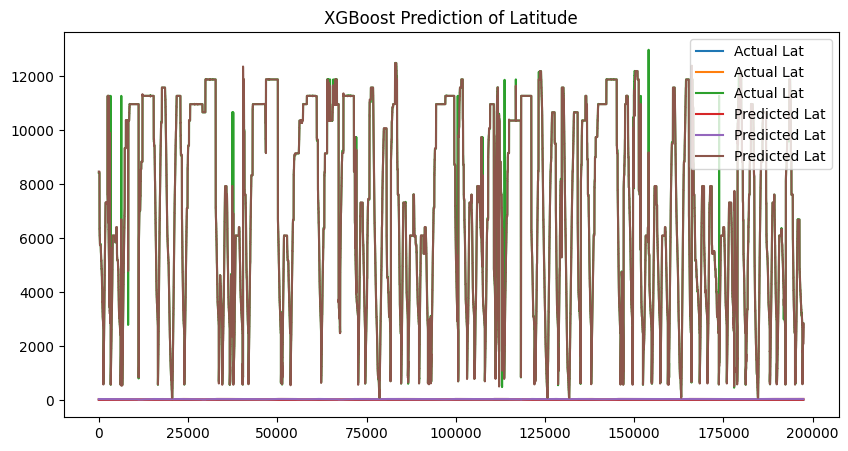

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Lat')
plt.plot(y_pred, label='Predicted Lat')
plt.legend()
plt.title('XGBoost Prediction of Latitude')
plt.show()


In [12]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

base_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, y_train)
y_pred = multi_model.predict(X_test)

for i, target in enumerate(y.columns):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print(f"{target} RMSE: {rmse}")

lat RMSE: 0.026672082361278958
lon RMSE: 0.07282326504357947
baroaltitude RMSE: 175.97033029340602


In [20]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


AttributeError: 'XGBRegressor' object has no attribute 'parameters'